In [ ]:
from fastai.basics import *
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.vision.augment import *
from fastai.vision.models.unet import *
from fastai.vision.learner import *
from fastai.vision.models import *
from fastai.callback.wandb import *
import wandb 

In [ ]:
wandb.init(project="mvtec")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marii (use `wandb login --relogin` to force relogin)


Dataset: https://www.mvtec.com/company/research/datasets/mvtec-ad

In [ ]:
data_url='https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz'

In [ ]:
dest=Path('/home/molly/.fastai/data/mvtec')

In [ ]:
#fastai doesn;t recognize .xz files
def file_extract(fname, dest=None):
    "Extract `fname` to `dest` using `tarfile` or `zipfile`."
    if dest is None: dest = Path(fname).parent
    fname = str(fname)
    if   fname.endswith('gz'):  tarfile.open(fname, 'r:gz').extractall(dest)
    elif fname.endswith('xz'):  tarfile.open(fname, 'r:xz').extractall(dest)
    elif fname.endswith('zip'): zipfile.ZipFile(fname     ).extractall(dest)
    else: raise Exception(f'Unrecognized archive: {fname}')

In [ ]:
path=untar_data(data_url,dest=dest,extract_func=file_extract) #breaks with '-' dashes?
path=path.parent
path.absolute()

Path('/home/molly/.fastai/data/mvtec')

In [ ]:
carpet_path=path/'carpet'/'test'
defect_folders=carpet_path.ls().map(lambda p:p.stem).filter(lambda p:p!='good')
image_files=get_image_files(carpet_path,folders=defect_folders)

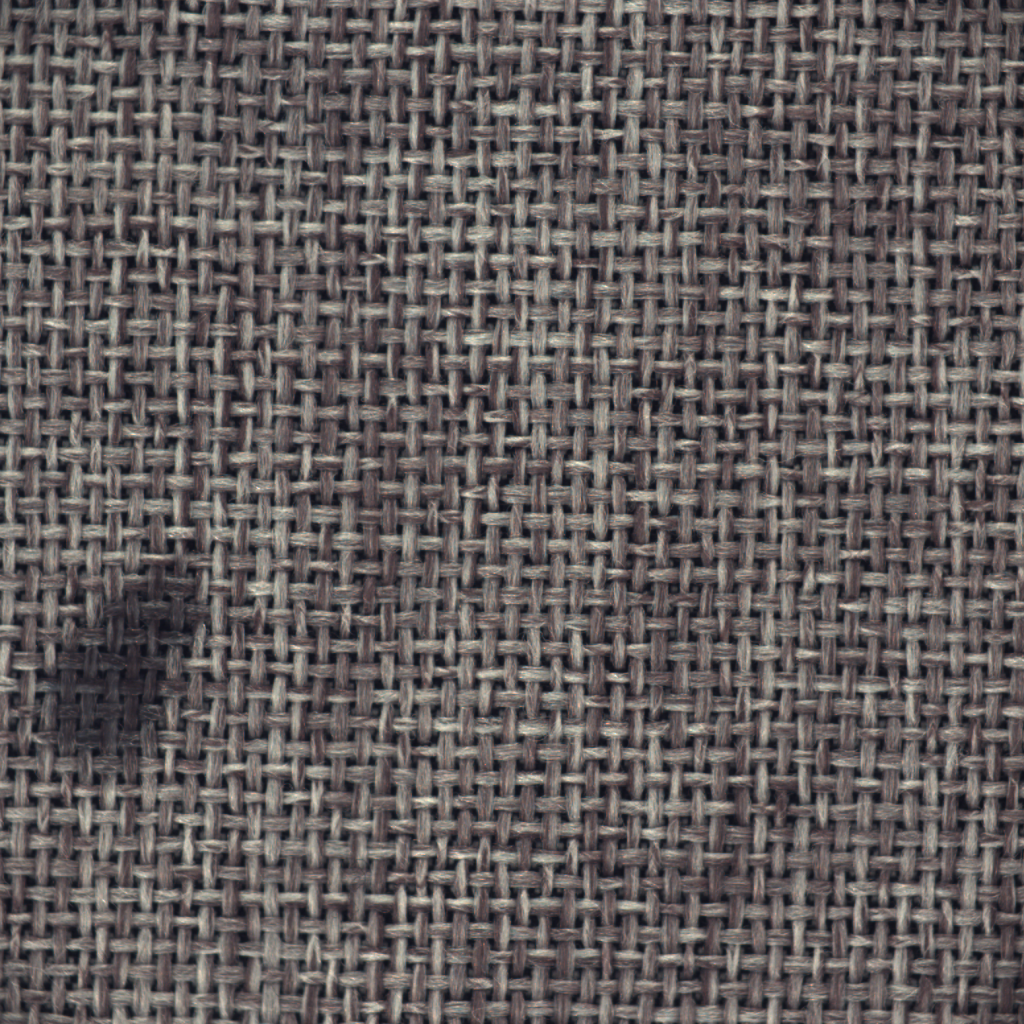

In [ ]:
Image.open(image_files[10])

In [ ]:
def label_func(p): return p.parent.parent.parent/'ground_truth'/p.parent.stem/(p.stem+'_mask'+p.suffix)

Realized the mask values are two values [0,255]. Divided by 255, where `div_mask=255.`, to work with pytorch. 

In [ ]:
@patch 
def encodes(self:SpaceTfm,x:TensorImage): 
    with torch.no_grad(): return self.space_fn(x,partial(compose_tfms, tfms=self.fs))

In [ ]:
image_tfms=aug_transforms(mult=1.0,
    do_flip=True,
    flip_vert=True,
    max_rotate=10.0,
    size=(512,512),
    min_zoom=1.0,
    max_zoom=2.,
    max_lighting=0.2,
    max_warp=0.2,
    p_affine=0.75,
    p_lighting=0.75,
    xtra_tfms=[Saturation(max_lighting=0.1, p=0.75),
               Hue(max_hue=0.1, p=0.75)],
    mode='bilinear',
    pad_mode='reflection',
    align_corners=True,
    batch=False,
    min_scale=1.0,)

In [ ]:
mvtec = DataBlock(blocks=(ImageBlock, MaskBlock(['good','bad'])),
                   get_items = partial(get_image_files,folders=defect_folders),
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=image_tfms+[IntToFloatTensor(div_mask=255.) ])

In [ ]:
Path('/home/molly/.fastai/data/mvtec/carpet/ground_truth/').ls()

(#5) [Path('/home/molly/.fastai/data/mvtec/carpet/ground_truth/color'),Path('/home/molly/.fastai/data/mvtec/carpet/ground_truth/cut'),Path('/home/molly/.fastai/data/mvtec/carpet/ground_truth/hole'),Path('/home/molly/.fastai/data/mvtec/carpet/ground_truth/metal_contamination'),Path('/home/molly/.fastai/data/mvtec/carpet/ground_truth/thread')]

In [ ]:
dls = mvtec.dataloaders(carpet_path,bs=8)

/home/molly/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/molly/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.


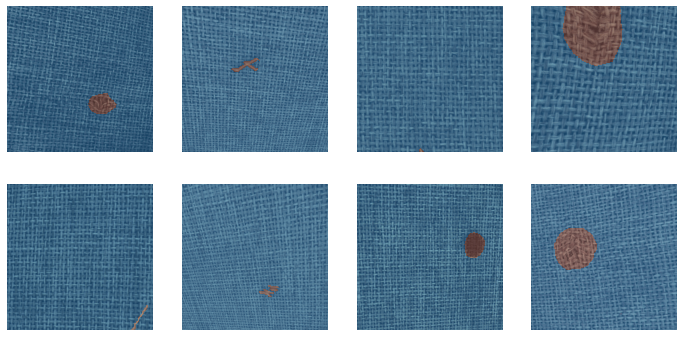

In [ ]:
dls.show_batch()

In [ ]:
learn = unet_learner(dls, resnet34,cbs=[WandbCallback]).to_fp16()
learn.freeze()
#learn.lr_find()

/home/molly/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
learn.fit_one_cycle(8,lr_max=0.0005)

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,time
0,0.400118,0.145424,00:16
1,0.257510,0.129266,00:11
2,0.207162,0.062711,00:11
3,0.167326,0.040351,00:11
4,0.151813,0.067021,00:11
5,0.136498,0.043058,00:11
6,0.119075,0.047067,00:11
7,0.107347,0.046842,00:11


In [ ]:
mvtec = DataBlock(blocks=(ImageBlock, MaskBlock(['good','bad'])),
                   get_items = partial(get_image_files,folders=defect_folders),
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=aug_transforms(size=(512,512))+[IntToFloatTensor(div_mask=255.) ])
dls = mvtec.dataloaders(carpet_path,bs=8)
learn.dls=dls

In [ ]:
#learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(8,lr_max=0.0001)

epoch,train_loss,valid_loss,time
0,0.039044,0.161476,00:11
1,0.033768,0.030548,00:11
2,0.030203,0.018334,00:11
3,0.027388,0.015318,00:11
4,0.024776,0.015260,00:11
5,0.022851,0.013926,00:11
6,0.021690,0.013675,00:11
7,0.020704,0.013845,00:11


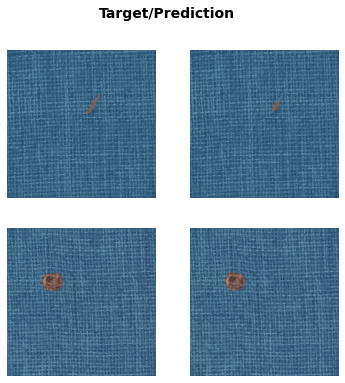

In [ ]:
learn.show_results(max_n=2)